# Project for Scientific Python - Krisztián Szemán

## Analysis of the football betting market

This project is an analysis of football games played in the English Premier League between seasons 2005-06 and 2017-18. The dataset contains 4940 games played in that span, and it has the following observations for each game:
* the teams playing the game
* the final score
* the average odds across several bookmakers for home win, draw and away win, respectively

The notebook can be separated into 3 parts:
* the first part is some exploratory analysis of the data: how big is the edge of bookmakers over the bettors, naive betting strategies, etc.
* in the second part, I test the occurence of a well-studied phenomenon, namely the favorite-longshot bias on this specific set of games.
* th third part is building a very simple models predicting the result of games and giving betting advice based on that.

## Part 1: Exploring the data

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import matplotlib as mpl

Reading in data

In [123]:
needed_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'BbAvH',
               'BbAvD', 'BbAvA']
data = pd.read_csv('E0 (1).csv')[needed_cols]
for i in range(2, 14):
    season = pd.read_csv('E0 (' + str(i) + ').csv')[needed_cols]
    if season.shape[0] != 380:
        season = season.iloc[ :380, :]
    data = pd.concat([data, season])

In [124]:
print("The dataset consists of " + str(data.shape[0]) + " rows and " + str(data.shape[1]) + " columns")

The dataset consists of 4940 rows and 9 columns


In [125]:
data.head(4)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,BbAvH,BbAvD,BbAvA
0,11/08/17,Arsenal,Leicester,4.0,3.0,H,1.51,4.43,6.44
1,12/08/17,Brighton,Man City,0.0,2.0,A,10.10,5.25,1.32
2,12/08/17,Chelsea,Burnley,2.0,3.0,A,1.24,6.06,13.67
3,12/08/17,Crystal Palace,Huddersfield,0.0,3.0,A,1.81,3.50,4.82


In [126]:
data.rename(columns = {'FTR': "Result", "BbAvH": "HomeOdds", "BbAvD": "DrawOdds",
                       "BbAvA": "AwayOdds" }, inplace = True)

In [127]:
data['HomeOdds'] = round(data["HomeOdds"], 2)
data['DrawOdds'] = round(data["DrawOdds"], 2)
data['AwayOdds'] = round(data["AwayOdds"], 2)

The average bettors loses, because the odds are set in such a way that for a sure win of one dollar, one should risk a little more than that. This is called the overround, which can be seen as e.g. the equivalent of the number zero in roulette.
### So what's this overround here?

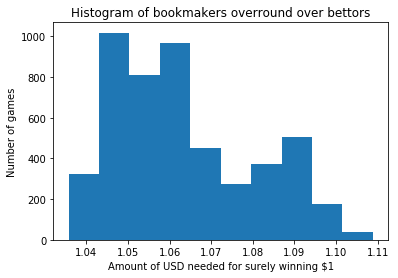

In [128]:
data['odds_check'] = 1/data["HomeOdds"] + 1/data["DrawOdds"] + 1/data["AwayOdds"]
plt.hist(data['odds_check'])
plt.title('Histogram of bookmakers overround over bettors')
plt.xlabel('Amount of USD needed for surely winning $1')
plt.ylabel('Number of games')
plt.show()

### Trying out some naive betting strategies

Betting always on:
* Team with higher chance (favorite)
* Team with lower chance (longshot)
* Draw
* Home team
* Away team

In [129]:
data['OddsFav'] = data[['HomeOdds', 'AwayOdds']].min(axis = 1)
data['PosFav'] = data[['HomeOdds', 'AwayOdds']].min(axis = 1) == data['HomeOdds']
data['OddsLongshot'] = data[['HomeOdds', 'AwayOdds']].max(axis = 1)

In [130]:
data["IsSuccessFav"] = data["PosFav"] * (data["Result"] == "H") + ((1 - data["PosFav"])) * (data["Result"] == "A")
data["IsSuccessDraw"] = (data["Result"] == "D")
data["IsSuccessLS"] = data["PosFav"] * (data["Result"] == "A") + ((1 - data["PosFav"])) * (data["Result"] == "H")

C:\Users\szmnk\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [131]:
def bet_success(col_odds, col_success, range_start, range_end, by, quality, indicator = 1):
    plt.subplots(figsize=(10, 4))
    plt.hist(data[col_odds], bins = np.arange(range_start, range_end, by), color = "r")
    plt.hist(data.loc[data[col_success] == indicator, col_odds], bins = np.arange(range_start, range_end, by), color = "g")
    plt.ylabel("Number of games")
    plt.xlabel("Odds")
    plt.legend(labels = ['Unsuccessful', 'Successful'], bbox_to_anchor=(1, 1, 0.35, 0))
    plt.title("How successful were bets on the " + quality + "?")
    plt.show()

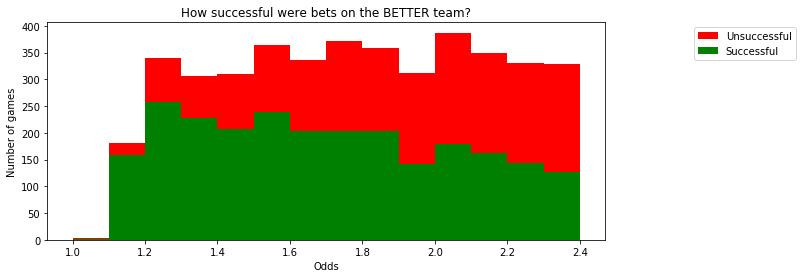

In [132]:
bet_success("OddsFav", "IsSuccessFav", 1, 2.5, 0.1, quality = "BETTER team")

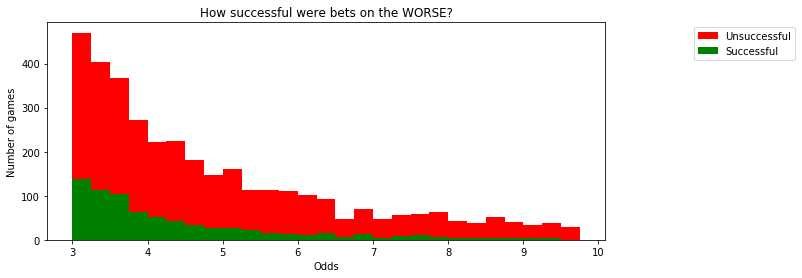

In [133]:
bet_success("OddsLongshot", "IsSuccessLS", 3.0, 10, 0.25, quality = "WORSE")

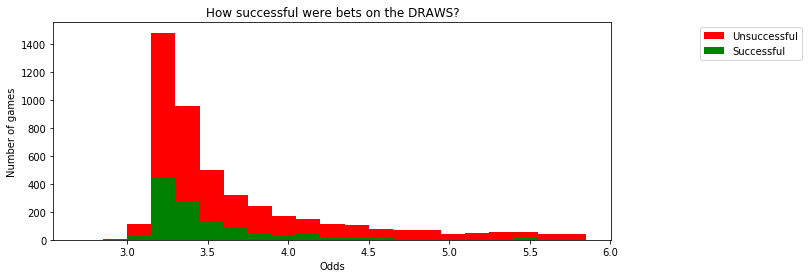

In [134]:
bet_success("DrawOdds", "Result", 2.7, 6, 0.15, quality = "DRAWS", indicator = "D")

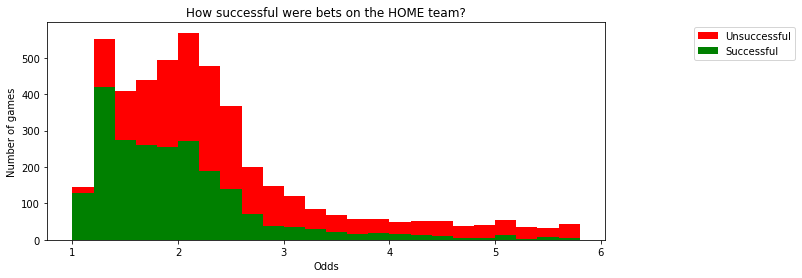

In [135]:
bet_success("HomeOdds", "Result", 1, 6, 0.2, quality = "HOME team", indicator = "H")

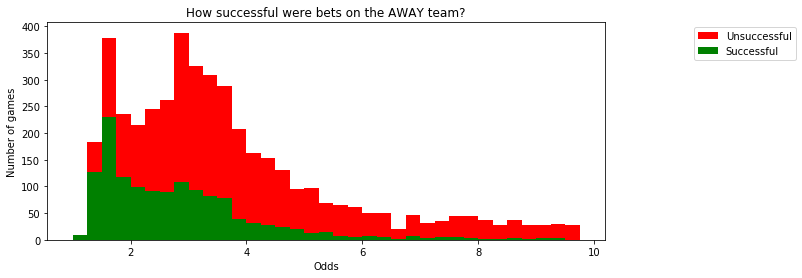

In [136]:
bet_success("AwayOdds", "Result", 1, 10, 0.25, quality = "AWAY team", indicator = "A")

### Would any of these 5 strategies have been profitable?

In [137]:
def profits(col_odds, col_success, indicator):
    return (round(sum(data.loc[data[col_success] == indicator, col_odds]) / data.shape[0] - 1, 4) * 100)

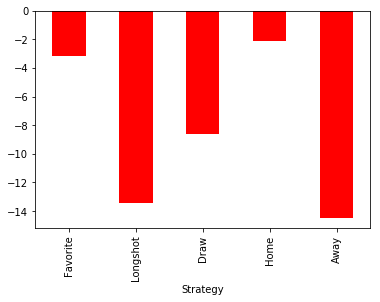

In [138]:
df = pd.DataFrame(columns=['Strategy','Profit'])
df['Strategy'] = ["Favorite", "Longshot", "Draw", "Home", "Away"]
df["Profit"] = [profits("OddsFav", "IsSuccessFav", 1), profits("OddsLongshot", "IsSuccessLS", 1),
                profits("DrawOdds", "Result", "D"), profits("HomeOdds", "Result", "H"),
                profits("AwayOdds", "Result", "A")]
df.plot(x = 'Strategy', y = 'Profit', kind = 'bar', color = "r", legend = False)
plt.show()

## Part 2: The favorite-longshot bias

Empirical fact: betting on the heavily favored team results in smaller loss in the long run, than betting on underdogs. Why is it so?

* bettors, and people in general tend to over-estimate the probability of unlikely events
* betting on huge odds and being successful is very appealing to a bettor, because it gives a sense of "superiority"
* risk-seeking: with the same expected value, bettors might prefer bets with higher variance

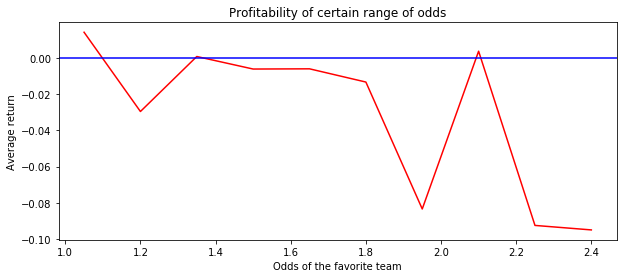

In [139]:
plt.subplots(figsize=(10, 4))
data["OddsFav"] * data["IsSuccessFav"]
gap = 0.15
bins = np.arange(1.05, 2.55, gap)
d = [[data[(data["OddsFav"] > b) & (data["OddsFav"] <= b + gap)].shape[0],
round(sum(data.loc[(data["OddsFav"] > b) & (data["OddsFav"] <= b + gap) & 
                   (data["IsSuccessFav"] == 1), "OddsFav"]), 2)] for b in bins]
favorite_returns = pd.DataFrame(d)
favorite_returns.rename(columns = {"0": "No_of_games", "1": "Avg_return"}, inplace = True)
favorite_returns[1] = favorite_returns[1] / favorite_returns[0] - 1
favorite_returns["Bin_min"] = bins
favorite_returns
plt.plot(favorite_returns.iloc[: ,2], favorite_returns.iloc[:, 1], color = "r")
plt.axhline(y = 0, xmin = 0, xmax = 1, color = "b")
plt.title("Profitability of certain range of odds")
plt.xlabel("Odds of the favorite team")
plt.ylabel("Average return")
plt.show()

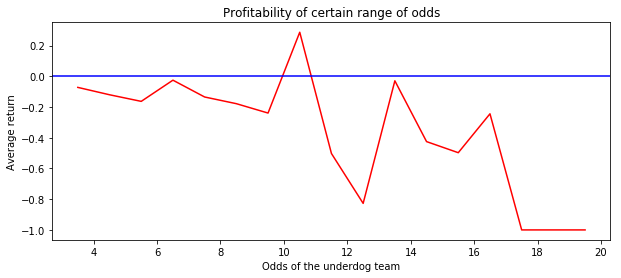

In [140]:
plt.subplots(figsize=(10, 4))
data["OddsLongshot"] * data["IsSuccessLS"]
gap = 1
bins = np.arange(3.5, 20, gap)
d = [[data[(data["OddsLongshot"] > b) & (data["OddsLongshot"] <= b + gap)].shape[0],
round(sum(data.loc[(data["OddsLongshot"] > b) & (data["OddsLongshot"] <= b + gap) & 
                   (data["IsSuccessLS"] == 1), "OddsLongshot"]), 2)] for b in bins]
favorite_returns = pd.DataFrame(d)
favorite_returns.rename(columns = {"0": "No_of_games", "1": "Avg_return"}, inplace = True)
favorite_returns[1] = favorite_returns[1] / favorite_returns[0] - 1
favorite_returns["Bin_min"] = bins
favorite_returns
plt.plot(favorite_returns.iloc[: ,2], favorite_returns.iloc[:, 1], color = "r")
plt.axhline(y = 0, xmin = 0, xmax = 1, color = "b")
plt.title("Profitability of certain range of odds")
plt.xlabel("Odds of the underdog team")
plt.ylabel("Average return")
plt.show()

### Problem
There are way too few observations in each bin for the curve to be smooth. How can we still estimate the expected return of a bet, based on only the odds?

# **Kernel regression to estimate expected return on a given odds**

Kernel regression is a tool of nonparametric statistics. It estimates E(Y) = f(X) based on the y-values of observations near the certain X-point. In some sense, it is similar to KNN.

Here I define a function for the Nadaraya-Watson kernel regression with a Gaussian kernel.

In [141]:
h = 0.15 #bandwidth for the Gauss-kernel
def kernel_reg(odds_x ,odds_column, success_column):
    distance = abs(1/odds_column - 1/odds_x)
    mult = np.exp(- (distance / h) ** 2)
    ret = mult * odds_column * success_column
    return sum(ret)/sum(mult) - 1

In [142]:
table = pd.DataFrame()
table["Odds"] = pd.concat([data["OddsFav"], data["OddsLongshot"]])
table["Success"] = pd.concat([data["IsSuccessFav"], data["IsSuccessLS"]])
odds = np.arange(1.01, 30, 0.01)
exp_return = []
for odd in odds:
        exp_return.append(kernel_reg(odd, table["Odds"], table["Success"]))
return_on_odds = pd.DataFrame()
return_on_odds["Odds"] = odds
return_on_odds["ExpectedReturn"] = exp_return

## The favorite longshot bias with smoothed curve

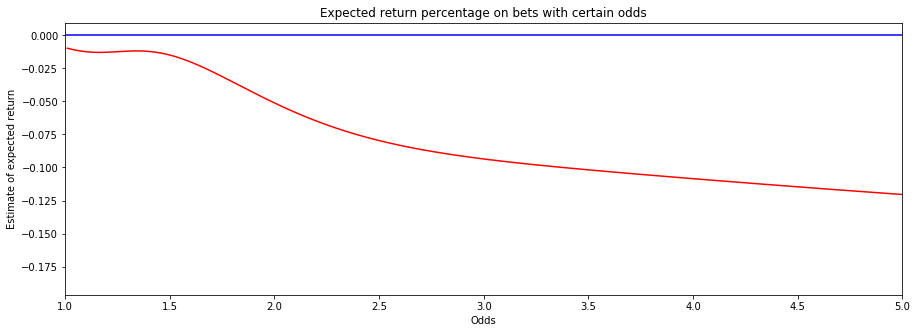

In [143]:
plt.subplots(figsize=(15,5))
plt.plot(odds, exp_return, color = "r")
plt.xlim(1, 5)
plt.axhline(y = 0, xmin = 0, xmax = 1, color = "b")
plt.title("Expected return percentage on bets with certain odds")
plt.xlabel("Odds")
plt.ylabel("Estimate of expected return")
plt.show()

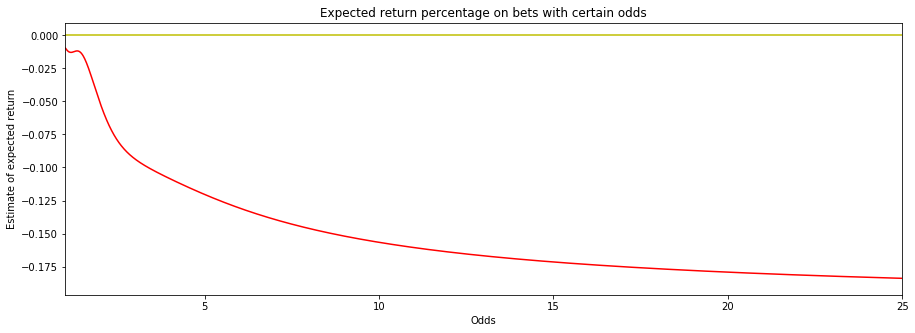

In [144]:
plt.subplots(figsize=(15,5))
plt.plot(odds, exp_return, color = "r")
plt.xlim(1, 25)
plt.axhline(y = 0, xmin = 0, xmax = 1, color = "y")
plt.title("Expected return percentage on bets with certain odds")
plt.xlabel("Odds")
plt.ylabel("Estimate of expected return")
plt.show()

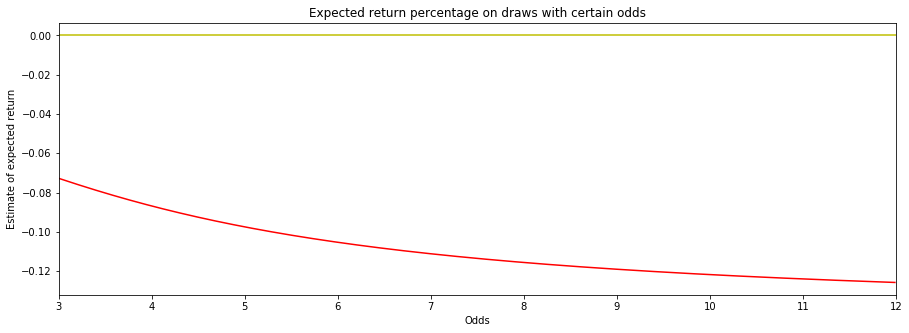

In [145]:
draw_odds = np.arange(2.8, 12, 0.01)
draw_exp_return = []
for odd in draw_odds:
        draw_exp_return.append(kernel_reg(odd, data["DrawOdds"], data["IsSuccessDraw"]))
return_on_draw = pd.DataFrame()
return_on_draw["Odds"] = draw_odds
return_on_draw["ExpectedReturn"] = draw_exp_return
plt.subplots(figsize=(15,5))
plt.plot(draw_odds, draw_exp_return, color = "r")
plt.xlim(3, 12)
plt.axhline(y = 0, xmin = 0, xmax = 1, color = "y")
plt.title("Expected return percentage on draws with certain odds")
plt.xlabel("Odds")
plt.ylabel("Estimate of expected return")
plt.show()

## Part 3: Building a simple betting model and testing it

Plus columns with points awarded

In [146]:
data['HomePoints'] = (data['Result'] == 'H') * 3 + (data['Result'] == 'D')
data['AwayPoints'] = (data['Result'] == 'A') * 3 + (data['Result'] == 'D')

In [147]:
format_str = '%d/%m/%y' # The format
date = []
date = [datetime.datetime.strptime(str(c), format_str) for c in data['Date']]
data['Date'] = date

In [148]:
season = [data.iloc[i, 0].year + (data.iloc[i, 0].month > 6) for i in range(sample_size)]
data['Season'] = season

In [117]:
data.head(5)

,Date,HomeTeam,AwayTeam,FTHG,FTAG,Result,HomeOdds,DrawOdds,AwayOdds,odds_check,OddsFav,PosFav,OddsLongshot,IsSuccessFav,IsSuccessDraw,IsSuccessLS,HomePoints,AwayPoints,Season
0,2017-08-11,Arsenal,Leicester,4.0,3.0,H,1.51,4.43,6.44,1.043265,1.51,True,6.44,1,False,0,3,0,2018
1,2017-08-12,Brighton,Man City,0.0,2.0,A,10.10,5.25,1.32,1.047062,1.32,False,10.10,1,False,0,0,3,2018
2,2017-08-12,Chelsea,Burnley,2.0,3.0,A,1.24,6.06,13.67,1.044621,1.24,True,13.67,0,False,1,0,3,2018
3,2017-08-12,Crystal Palace,Huddersfield,0.0,3.0,A,1.81,3.50,4.82,1.045669,1.81,True,4.82,0,False,1,0,3,2018
4,2017-08-12,Everton,Stoke,1.0,0.0,H,1.69,3.69,5.50,1.044537,1.69,True,5.50,1,False,0,3,0,2018


# Getting information of the already played games

Just some data formatting: getting the number of points of a team before each round, etc.

In [151]:
def game_no(row, home = True):
    s = row['Season']
    d = row['Date']
    if home:
        team = row['HomeTeam']
    else:
        team = row['AwayTeam']
    table = data[data['Season'] == s]
    prev_hg = table[(table['HomeTeam'] == team) & (table['Date'] < d)]
    prev_ag = table[(table['AwayTeam'] == team) & (table['Date'] < d)]
    #pts_season = sum(home_games['HomePoints']) + sum(away_games['AwayPoints'])
    pts_before = sum(prev_hg['HomePoints']) + sum(prev_ag['AwayPoints'])
    games_before = prev_hg.shape[0] + prev_ag.shape[0]
    return [pts_before, games_before]

In [152]:
def total_pts(row, home = True):
    s = row['Season']
    d = row['Date']
    if home:
        team = row['HomeTeam']
    else:
        team = row['AwayTeam']
    table = data[data['Season'] == s]
    hg = table[(table['HomeTeam'] == team)]
    ag = table[(table['AwayTeam'] == team)]
    pts_season = sum(hg['HomePoints']) + sum(ag['AwayPoints'])
    return pts_season

In [153]:
home_games_before = [game_no(data.iloc[i, :], home = True) for i in range(sample_size)]
away_games_before = [game_no(data.iloc[i, :], home = False) for i in range(sample_size)]

In [154]:
data['HomePB'] = [c[0] for c in home_games_before]
data['HomeGB'] = [c[1] for c in home_games_before]
data['AwayPB'] = [c[0] for c in away_games_before]
data['AwayGB'] = [c[1] for c in away_games_before]

In [155]:
data['HomeTP'] = [total_pts(data.iloc[i, :], home = True) for i in range(sample_size)]
data['AwayTP'] = [total_pts(data.iloc[i, :], home = False) for i in range(sample_size)]

In [157]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,Result,HomeOdds,DrawOdds,AwayOdds,odds_check,...,IsSuccessLS,HomePoints,AwayPoints,Season,HomePB,HomeGB,AwayPB,AwayGB,HomeTP,AwayTP
0,2017-08-11,Arsenal,Leicester,4.0,3.0,H,1.51,4.43,6.44,1.043265,...,0,3,0,2018,0,0,0,0,63,47
1,2017-08-12,Brighton,Man City,0.0,2.0,A,10.10,5.25,1.32,1.047062,...,0,0,3,2018,0,0,0,0,40,100
2,2017-08-12,Chelsea,Burnley,2.0,3.0,A,1.24,6.06,13.67,1.044621,...,1,0,3,2018,0,0,0,0,70,54
3,2017-08-12,Crystal Palace,Huddersfield,0.0,3.0,A,1.81,3.50,4.82,1.045669,...,1,0,3,2018,0,0,0,0,44,37
4,2017-08-12,Everton,Stoke,1.0,0.0,H,1.69,3.69,5.50,1.044537,...,0,3,0,2018,0,0,0,0,49,33


In [314]:
train = data[data['Season'] < 2015]
test = data[data['Season'] >= 2015]
print(train.shape, test.shape)

(3420, 25) (1520, 25)


# Estimating total season points after n rounds

In [162]:
needed_cols = ['HomePB', 'HomeGB', 'HomeTP', 'AwayPB', 'AwayGB', 'AwayTP']
table1 = data[needed_cols[:3]]
table2 = data[needed_cols[3:]]
table1 = table1.rename(columns={"HomePB": "PointsBefore", "HomeGB": "Games", "HomeTP": "PointsTotal"})
table2 = table2.rename(columns={"AwayPB": "PointsBefore", "AwayGB": "Games", "AwayTP": "PointsTotal"})
table = pd.concat([table1, table2])
table[100:110]

,PointsBefore,Games,PointsTotal
100,12,10,37
101,14,10,44
102,13,10,36
103,11,10,33
104,8,10,33
105,9,10,42
106,19,10,70
107,8,10,49
108,28,10,100
109,20,10,77


In this part, a simple logistic regression is used in order to answer the following question:

### If a team has x many points after n rounds, how many points is it going to have at the end of the season?

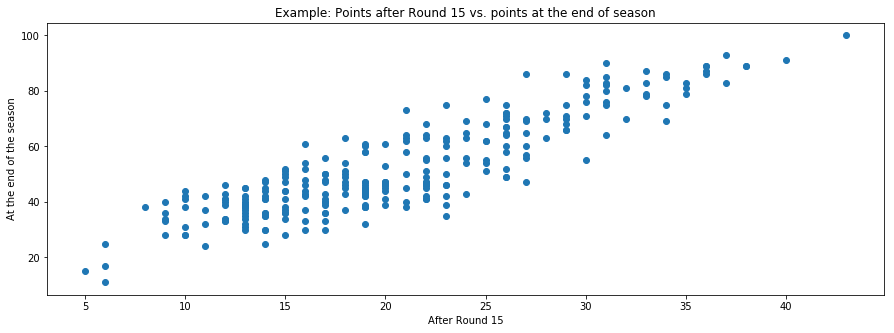

In [164]:
s = table[table["Games"] == 15]
plt.subplots(figsize = (15, 5))
plt.scatter(s['PointsBefore'], s['PointsTotal'])
plt.title("Example: Points after Round 15 vs. points at the end of season")
plt.xlabel("After Round 15")
plt.ylabel("At the end of the season")
plt.show()

# Linear regression for estimation

In [165]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import statsmodels.regression.linear_model as sm

In [168]:
reg_dict = dict()
for i in range(10, 38):
    s = table[table["Games"] == i]
    X = pd.DataFrame()
    X['Points_before'] = s['PointsBefore']
    X['Constant'] = 1
    y = s['PointsTotal']
    model = sm.OLS(y, X).fit()
    col1 = 'Mult_' + str(i)
    col2 = 'Const_' + str(i)
    reg_dict[col1] = model.params[0]
    reg_dict[col2] = model.params[1]
reg_dict['Mult_14'], reg_dict['Const_14']

(2.1236493945512454, 11.469190466112616)

In [169]:
def mult(a):
    return reg_dict['Mult_' + str(a)] if int(a) >= 10 else 0
def const(a):
    return reg_dict['Const_' + str(a)] if int(a) >= 10 else 0

In [170]:
def exp_pts(row, home = True):
    a = row["HomePB"] * mult(row["HomeGB"]) + const(row["HomeGB"])
    return a if home else row["AwayPB"] * mult(row["AwayGB"]) + const(row["AwayGB"])

In [171]:
data["HomeExp"] = [exp_pts(data.iloc[i, : ]) for i in range(sample_size)]
data["AwayExp"] = [exp_pts(data.iloc[i, : ], home = False) for i in range(sample_size)]

In [172]:
data.tail()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,Result,HomeOdds,DrawOdds,AwayOdds,odds_check,...,AwayPoints,Season,HomePB,HomeGB,AwayPB,AwayGB,HomeTP,AwayTP,HomeExp,AwayExp
375,2006-05-07,Fulham,Middlesbrough,1.0,0.0,H,1.65,3.43,5.01,1.097207,...,0,2006,45,37,45,37,48,45,46.228618,46.228618
376,2006-05-07,Man United,Charlton,4.0,0.0,H,1.20,5.56,12.26,1.094756,...,0,2006,80,37,47,37,83,47,82.258041,48.287442
377,2006-05-07,Newcastle,Chelsea,1.0,0.0,H,2.82,3.18,2.33,1.098260,...,0,2006,55,37,91,37,58,91,56.522739,93.581574
378,2006-05-07,Portsmouth,Liverpool,1.0,3.0,A,5.11,3.62,1.59,1.100869,...,3,2006,38,37,79,37,38,82,39.022733,81.228629
379,2006-05-07,West Ham,Tottenham,2.0,1.0,H,4.23,3.47,1.73,1.102626,...,0,2006,52,37,65,37,55,65,53.434503,66.816860


In [173]:
data = data[(data["HomeGB"] >= 10) & (data["HomeExp"] >= 10) & (data["HomeGB"] < 35) & (data["AwayGB"] < 35)]
train = data[data['Season'] < 2015]
test = data[data['Season'] >= 2015]
train.shape, test.shape

((2239, 27), (989, 27))

In [175]:
needed_cols = ['Result', 'HomeOdds', 'DrawOdds', 'AwayOdds', 'HomeExp', 'AwayExp']
train = train[needed_cols]
test = test[needed_cols]

In [176]:
train['Result'] = (train['Result'] == 'H') + (train['Result'] == 'D') * 2 + (train['Result'] == 'A') * 3
test['Result'] = (test['Result'] == 'H') + (test['Result'] == 'D') * 2 + (test['Result'] == 'A') * 3

C:\Users\szmnk\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [178]:
from sklearn.linear_model import LogisticRegression

## Multinomial logistic regression

The aim is to estimate the probability of a game being a home win, a draw or an away win, respectively. It happens using only the previously estimated "expected points at the end of the season" and the fact that who plays at home.

In [179]:
log = LogisticRegression(solver = 'newton-cg', multi_class = 'multinomial')
X = train.iloc[:, [4, 5]].values
y = train.iloc[:, 0].values
X_test = test.iloc[:, [4, 5]].values
model = log.fit(X, y)
model.coef_, model.intercept_
y_pred = log.predict_proba(X_test)

In [180]:
test["HomeP"] = [c[0] for c in y_pred]
test["DrawP"] = [c[1] for c in y_pred]
test["AwayP"] = [c[2] for c in y_pred]

In [181]:
test.head()

,Result,HomeOdds,DrawOdds,AwayOdds,HomeExp,AwayExp,HomeP,DrawP,AwayP
100,1,2.73,2.96,2.93,47.871890,42.771401,0.512391,0.271095,0.216513
101,3,1.98,3.42,4.05,52.972379,35.120667,0.602996,0.250647,0.146357
102,3,1.64,3.64,6.20,50.422135,58.072869,0.427668,0.275307,0.297025
103,2,2.65,3.25,2.77,45.321645,47.871890,0.455226,0.277526,0.267248
104,3,2.38,3.10,3.29,37.670911,47.871890,0.388888,0.281523,0.329589


## Creating a betting model

### Main ideas:
* a bet may be profitable if the probability times the odds is higher than one
* home bets and favorite bets have shown to be more profitabl

In [182]:
test["ReturnH"] = test['HomeOdds'] * test['HomeP']
test["ReturnD"] = test['DrawOdds'] * test['DrawP']
test["ReturnA"] = test['AwayOdds'] * test['AwayP']

In [183]:
test['BetH'] = test["ReturnH"] > 1
test['BetD'] = test["ReturnD"] > 1
test['BetA'] = test["ReturnA"] > 1

In [184]:
home_bets = test[test['BetH'] == True]
home_bets = home_bets[["Result", "HomeOdds", "HomeP", "ReturnH"]]
draw_bets = test[test['BetD'] == True]
draw_bets = draw_bets[["Result", "DrawOdds", "DrawP", "ReturnD"]]
away_bets = test[test['BetA'] == True]
away_bets = away_bets[["Result", "AwayOdds", "AwayP", "ReturnA"]]

In [185]:
home_bets["Is_successful"] = home_bets["Result"] == 1
draw_bets["Is_successful"] = draw_bets["Result"] == 2
away_bets["Is_successful"] = away_bets["Result"] == 3
home_bets["Return"] = home_bets["Is_successful"] * home_bets["HomeOdds"]
draw_bets["Return"] = draw_bets["Is_successful"] * draw_bets["DrawOdds"]
away_bets["Return"] = away_bets["Is_successful"] * away_bets["AwayOdds"]

We search for 3 things: 1) Whether the model says expected profit is greater than zero 2) Whether the team to be backed is home 3) Whether the team to be backed is a heavy favorite (odds < 1.5)

### 4 different strategies:
* 1 holds
* 1 and 2 hold
* 1 and 3 hold
* 1, 2, and 3 all hold

In [187]:
home_bets.head()

,Result,HomeOdds,HomeP,ReturnH,Is_successful,Return
100,1,2.73,0.512391,1.398829,True,2.73
101,3,1.98,0.602996,1.193932,False,0.00
103,2,2.65,0.455226,1.206348,False,0.00
105,3,5.17,0.339831,1.756929,False,0.00
106,1,2.47,0.434790,1.073932,True,2.47


In [197]:
A = round((sum(home_bets["Return"]) + sum(draw_bets["Return"]) +
     sum(away_bets["Return"])) / (home_bets.shape[0] +
        draw_bets.shape[0] + away_bets.shape[0]) - 1, 4)
B = round(sum(home_bets["Return"]) / home_bets.shape[0] - 1, 4)

In [199]:
home_bets = home_bets[home_bets["HomeOdds"] <= 1.5]
away_bets = away_bets[away_bets["AwayOdds"] <= 1.5]

In [200]:
C = round((sum(home_bets["Return"]) +
     sum(away_bets["Return"])) / (home_bets.shape[0] +
        away_bets.shape[0]) - 1, 4)
D = round(sum(home_bets["Return"]) / home_bets.shape[0] - 1, 4)

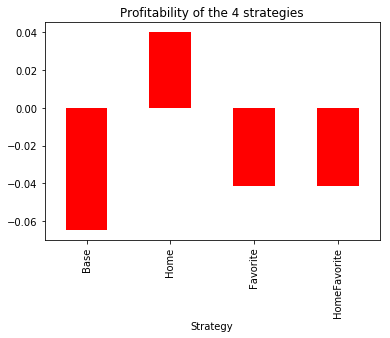

In [202]:
df = pd.DataFrame(columns=['Strategy','Profit'])
df['Strategy'] = ["Base", "Home", "Favorite", "HomeFavorite"]
df["Profit"] = [A, B, C, D]
df.plot(x = 'Strategy', y = 'Profit', kind = 'bar', color = "r", legend = False)
plt.title("Profitability of the 4 strategies")
plt.show()